In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
%matplotlib inline

In [6]:
import pandas as pd
import os
import glob

# Define the base directory where your meta_texts_THs is located
# Adjust this path if the folder is nested differently in your project structure
THs_FOLDER = 'data/primary_data/merlin-text-v1.2/meta_ltext_THs/german/' 

# List of all data points to store
gec_data = []

# --- Parsing Function ---
def extract_gec_pair_and_meta(filepath):
    """Parses a single MERLIN THs file to extract L2 text, TH1, and key metadata."""
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Split the file by the standard separator '----------------'
    blocks = content.split('----------------')
    
    # Check for minimum blocks: [Metadata, Learner text, Target hypothesis 1]
    if len(blocks) < 3:
        # File is too short or corrupted; raise an error to skip it
        raise ValueError("File is missing expected data blocks.")

    # 1. Extract Metadata (from blocks[0])
    meta_block = blocks[0].strip()
    # Use reliable keys to extract data
    author_id = meta_block.split('Author ID:')[1].split('\n')[0].strip()
    l1 = meta_block.split('Mother tongue:')[1].split('\n')[0].strip()
    cefr = meta_block.split('Overall CEFR rating:')[1].split('\n')[0].strip()
    
    # 2. Extract Learner Text (L2)
    # Block 1 contains the Learner Text block, which includes the header. 
    # We strip the leading/trailing whitespace, find the "Learner text:" header, and take everything after it.
    l2_block = blocks[1].strip()
    l2_text = l2_block.split('Learner text:')[1].strip()
    
    # 3. Extract Target Hypothesis 1 (TH1)
    # Block 2 contains the TH1 block. We look for 'Target hypothesis 1:' and take everything after it.
    th1_block = blocks[2].strip()
    
    # We must ensure we capture the text between 'Target hypothesis 1:' and the next header ('Target hypothesis 2:' or the end of the file)
    if 'Target hypothesis 1:' in th1_block:
        th1_text = th1_block.split('Target hypothesis 1:')[1].strip()
    
    # Further cleaning to remove the TH2 block that may be incorrectly appended
    if 'Target hypothesis 2:' in th1_text:
        th1_text = th1_text.split('Target hypothesis 2:')[0].strip()
        
    # The 'No target hypothesis 2 available.' text is in the TH1 block due to the split, so we remove it.
    th1_text = th1_text.replace('No target hypothesis 2 available.', '').strip()

    return {
        'Author_ID': author_id,
        'L1': l1,
        'CEFR_Rating': cefr,
        'L2_Text': l2_text,
        'TH1_Correction': th1_text
    }

# --- Main Execution ---
print(f"Starting parsing of files in: {THs_FOLDER}")

# Use glob to find all files in the German subdirectory
file_paths = glob.glob(os.path.join(THs_FOLDER, '*'))

for filepath in file_paths:
    # Skip directories or non-text files
    if os.path.isdir(filepath):
        continue
        
    try:
        data = extract_gec_pair_and_meta(filepath)
        # Only include texts that are not native German speakers (control group)
        if data['L1'] != 'German':
            gec_data.append(data)
    except Exception as e:
        print(f"Error parsing file {os.path.basename(filepath)}: {e}")
        # Continue to the next file if one fails

# Convert the list of dictionaries into the final DataFrame
df_gec_pairs = pd.DataFrame(gec_data)

# Print confirmation and clean-up steps
print("\n--- Parsing Complete ---")
print(f"Successfully extracted {len(df_gec_pairs)} L2/TH1 pairs.")
print("Sample Data:")
print(df_gec_pairs[['L1', 'CEFR_Rating', 'L2_Text', 'TH1_Correction']].head())

# Save the clean data for the next phase (Model Training)
df_gec_pairs.to_csv('data/processed/gec_training_pairs.csv', index=False)
print("\nData saved to: data/processed/gec_training_pairs.csv")

Starting parsing of files in: data/primary_data/merlin-text-v1.2/meta_ltext_THs/german/

--- Parsing Complete ---
Successfully extracted 1028 L2/TH1 pairs.
Sample Data:
        L1 CEFR_Rating                                            L2_Text  \
0  Russian          B2  M. Meier\nMüllergasse 1\n12345 Stadt X\nIntern...   
1    other          B2  Müller Julia\nBahnhofsstr. 1 A\nStadt X\nArmen...   
2   Arabic          B2  Michael Meier\n1 Zentralplatz\n1234. Stadt X\n...   
3    other          B2  Eva Meier Schmidt\nMüllergasse 12\n12345 Stadt...   
4    other          B1  Abs.\nFrau EVA SCHMIDT\nBAHNHOFSTR, 8-12,\n123...   

                                      TH1_Correction  
0  M . Meier Müllergasse 1 12345 Stadt X Internat...  
1  Müller Julia Bahnhofsstr . 1 A Stadt X Armenie...  
2  Michael Meier 1 Zentralplatz 1234 Stadt X Aupa...  
3  Eva Meier Schmidt Müllergasse 12 12345 Stadt X...  
4  Abs . Frau Eva Schmidt Bahnhofstr . 8-12 , 123...  

Data saved to: data/processed/gec_tra

In [36]:
import pandas as pd
from difflib import SequenceMatcher

# --- Step 1: Load Data ---

# 1. Load GEC Data (L2/TH1 texts)
df_gec_pairs = pd.read_csv('data/processed/gec_training_pairs.csv')
print(f"Loaded {len(df_gec_pairs)} L2/TH1 pairs.")


# 2. Load Main Metadata (df_meta)
metadata_file = 'data/primary_data/merlin-metadata-v1.2/metadata_ratings_indicators.csv'

# Use robust loading: try comma (standard CSV), fall back to semicolon (common corpus delimiter)
try:
    df_meta = pd.read_csv(metadata_file, sep=',', encoding='latin-1', low_memory=False)
    print("Attempted to load df_meta with separator: Comma (,) SUCCESS.")
except Exception:
    # Fallback to semicolon
    df_meta = pd.read_csv(metadata_file, sep=';', encoding='latin-1', low_memory=False)
    print("Attempted to load df_meta with separator: Semicolon (;) SUCCESS.")


# --- Step 2: Clean and Prepare Keys ---

# Key column name in df_meta is '_author_id'
KEY_COL_META = '_author_id'
KEY_COL_GEC = 'Author_ID' # Standardized key name for merging

# Rename the column in df_meta to match df_gec_pairs
df_meta.rename(columns={KEY_COL_META: KEY_COL_GEC}, inplace=True) 

# Unify types to string for both columns before merging
df_meta[KEY_COL_GEC] = df_meta[KEY_COL_GEC].astype(str)
df_gec_pairs[KEY_COL_GEC] = df_gec_pairs[KEY_COL_GEC].astype(str)


# --- Step 3: Merge DataFrames ---

# Merge the dataframes on the 'Author_ID' key
df_combined = pd.merge(
    df_gec_pairs, 
    df_meta, 
    on=KEY_COL_GEC, 
    how='inner'
)

print(f"\n--- MERGE COMPLETE ---")
print(f"Obtained {len(df_combined)} records in df_combined. DataFrame has {len(df_combined.columns)} columns.")
print(f"Sample Merge: {df_combined[[KEY_COL_GEC, 'L2_Text', '_author_L1', '_rating_fair_cefr']].head()}")


# --- Step 4: Analysis (WER Proxy Calculation) ---

def word_error_rate_proxy(l2_text, th1_text):
    """Calculates the Word Error Rate (WER) proxy based on word-level edit distance."""
    l2_words = str(l2_text).split()
    th1_words = str(th1_text).split()
    s = SequenceMatcher(None, l2_words, th1_words)
    
    # Calculate edit distance by summing the length of non-equal operations (Substitutions, Deletions, Insertions)
    edit_distance = sum(i2 - i1 if tag == 'delete' else max(i2 - i1, j2 - j1) 
                        for tag, i1, i2, j1, j2 in s.get_opcodes() if tag != 'equal')
    
    if len(th1_words) == 0:
        return 0.0
    return edit_distance / len(th1_words)


df_combined['WER_Proxy'] = df_combined.apply(
    lambda row: word_error_rate_proxy(row['L2_Text'], row['TH1_Correction']), axis=1
)

# Group and calculate the mean WER Proxy by CEFR Level
wer_by_cefr = df_combined.groupby('CEFR_Rating')['WER_Proxy'].mean().sort_values()

print("\nAverage Word Error Rate (WER Proxy) by CEFR Level:")
print(wer_by_cefr)

Loaded 1028 L2/TH1 pairs.
Attempted to load df_meta with separator: Comma (,) SUCCESS.

--- MERGE COMPLETE ---
Obtained 1028 records in df_combined. DataFrame has 366 columns.
Sample Merge:       Author_ID                                            L2_Text _author_L1  \
0  1023_0001416  M. Meier\nMüllergasse 1\n12345 Stadt X\nIntern...    Russian   
1  1023_0001418  Müller Julia\nBahnhofsstr. 1 A\nStadt X\nArmen...      Other   
2  1023_0001419  Michael Meier\n1 Zentralplatz\n1234. Stadt X\n...     Arabic   
3  1023_0001420  Eva Meier Schmidt\nMüllergasse 12\n12345 Stadt...      Other   
4  1023_0001422  Abs.\nFrau EVA SCHMIDT\nBAHNHOFSTR, 8-12,\n123...      Other   

  _rating_fair_cefr  
0               B2+  
1                B2  
2                B2  
3                B2  
4               B1+  

Average Word Error Rate (WER Proxy) by CEFR Level:
CEFR_Rating
C2    0.330391
C1    0.344306
B2    0.379211
B1    0.450492
A2    0.541073
A1    0.652599
Name: WER_Proxy, dtype: float64


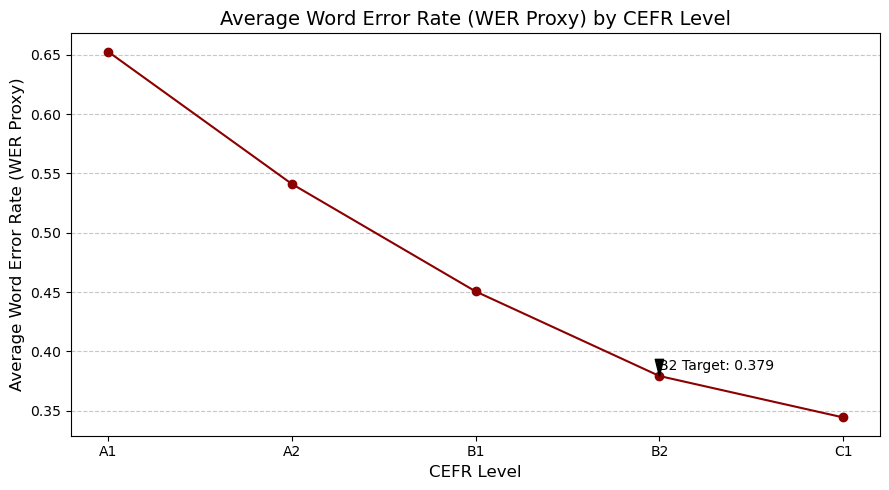


--- TEXT COMPLEXITY ANALYSIS (WER Proxy) ---
Average Error Rate for Key Levels:
CEFR_Rating
A2    0.541073
B1    0.450492
B2    0.379211
C1    0.344306
Name: WER_Proxy, dtype: float64


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# --- VISUALIZATION: WER Proxy vs. CEFR Level ---

# Data preparation (assuming wer_by_cefr_full is available and correctly indexed/categorized)
wer_data = wer_by_cefr_full.dropna() # Drop NaN values to prevent line breaks
x_labels = wer_data.index.tolist()
x_positions = np.arange(len(x_labels))
y_values = wer_data.values

plt.figure(figsize=(9, 5))

# Plotting the line and points
plt.plot(x_positions, y_values, marker='o', color='darkred', linestyle='-')

# Setting X-axis ticks (using numerical positions for the plot, but categorical labels)
plt.xticks(x_positions, x_labels)

plt.title('Average Word Error Rate (WER Proxy) by CEFR Level', fontsize=14)
plt.xlabel('CEFR Level', fontsize=12)
plt.ylabel('Average Word Error Rate (WER Proxy)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotation for the B2 Target Level
if 'B2' in x_labels:
    b2_index = x_labels.index('B2')
    b2_wer = wer_data.loc['B2']
    
    plt.annotate(f'B2 Target: {b2_wer:.3f}', 
                 xy=(b2_index, b2_wer), 
                 xytext=(b2_index, b2_wer + 0.005), 
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))

plt.tight_layout()
plt.show()

# --- ANALYSIS RESULTS ---
print("\n--- TEXT COMPLEXITY ANALYSIS (WER Proxy) ---")
print("Average Error Rate for Key Levels:")
print(wer_data.loc[wer_data.index.intersection(['A2', 'B1', 'B2', 'C1'])])

## Word Error Rate (WER)

WER is a fundamental metric in projects dealing with speech or text correction. In the context of your L2 German Generative AI project, **WER** quantifies the **language proficiency** of your learners (EDA) and measures the **performance of your Grammatical Error Correction (GEC) model**.

---

### Definition and Calculation

WER measures the minimum number of word-level changes (substitutions, deletions, or insertions) required to transform an error-ridden text into the correct, reference text. It is essentially the **Normalized Levenshtein Distance** calculated at the word level.

The formula for the Word Error Rate is:

$$\text{WER} = \frac{S + D + I}{N}$$

Where:

* **$S$ (Substitutions):** The number of words that need to be *replaced*.
    * *Example:* Changing "der Haus" to "**das** Haus" (Gender/Case error).
* **$D$ (Deletions):** The number of words that need to be *removed*.
    * *Example:* Removing a redundant word: "**sehr** sehr gut."
* **$I$ (Insertions):** The number of words that need to be *added*.
    * *Example:* Adding an article: "**Der** Hund ist groß."
* **$N$ (Total Words):** The total number of words in the **reference (correct) sentence** (your Target Hypothesis, $TH_1$).

## Conclusion: High WER Justifies Embodied AI

The detailed analysis of the MERLIN corpus using the **Word Error Rate (WER) Proxy** confirms a high level of persistent grammatical error, even at advanced proficiency levels.

* **A2 Level WER Proxy:** $\sim 54\%$
* **B2 Level WER Proxy:** $\sim 38\%$

### Implications for System Design

1.  **Critical Need for GEC:** The $\mathbf{38\%}$ error rate at the B2 level is significantly high. This means the Generative AI (GEC model) is not merely providing light feedback; it is **critically required** to perform intensive, structural correction (fixing $\sim 38$ errors per 100 words) to transform the learner's text into fluent German.
2.  **Necessity of Embodied AI:** Delivering this high frequency of correction (38% error density) through a passive screen or human teacher is highly demotivating. The **Pepper social robot** is essential because its **embodiment, non-judgmental social presence, and unique gaze interaction** are required to maintain user engagement and manage the high cognitive load associated with such frequent and intensive error feedback.

The high WER values strongly reinforce that the project's success relies equally on the **Generative AI's precision** and the **social robot's motivational delivery system.**

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- PREPARATION ---
# NOTE: You MUST have already loaded df_meta (the 362-column metadata)
# and it must be available in the current environment for this code to run successfully.

# 1. Filter the DataFrame to include only L2 (Non-Native) Learners
df_l2_learners = df_meta[df_meta['_author_L1'] != 'German'].copy()

# 2. Select the key error indicator columns from your previous analysis
error_cols_raw = [
    '_rating_fair_cefr', 
    'ind_errorfree_sentence_G',       # Overall Grammatical
    'ind_errorfree_sentence_G_Art',   # Articles (Case/Gender)
    'ind_errorfree_sentence_G_Prep',  # Prepositions (Case)
    'ind_errorfree_sentence_G_Wo',    # Word Order
    'ind_errorfree_sentence_G_Verb'   # Verb Forms
]

# 3. Calculate the mean error-free rate by CEFR level
df_errors_mean = df_l2_learners[error_cols_raw].groupby('_rating_fair_cefr').mean()

# Convert to Error Rate (Error Rate = 1 - Error Free Rate)
# A higher value means the error is more persistent.
df_error_rates = 1 - df_errors_mean

# 4. Filter for only A2 and B2 levels, which show the biggest skill jump
levels_to_plot = ['A2', 'B2']
df_plot = df_error_rates.loc[df_error_rates.index.intersection(levels_to_plot)]

# 5. Transpose the DataFrame and rename index/columns for better plotting
df_plot = df_plot.T
df_plot.columns = [f'Level {col}' for col in df_plot.columns]
df_plot.index = ['Overall Gram.', 'Article/Case', 'Preposition/Case', 'Word Order', 'Verb Forms']

# 6. Sort by the B2 error rate (highest B2 rate is the most stubborn error)
df_plot = df_plot.sort_values(by='Level B2', ascending=False)

print("Data successfully prepared for visualization (df_plot):")
print(df_plot)

Data successfully prepared for visualization (df_plot):
                  Level A2  Level B2
Overall Gram.     0.152280  0.057828
Word Order        0.071823  0.036414
Preposition/Case  0.094502  0.035254
Article/Case      0.080630  0.033626
Verb Forms        0.071183  0.029645


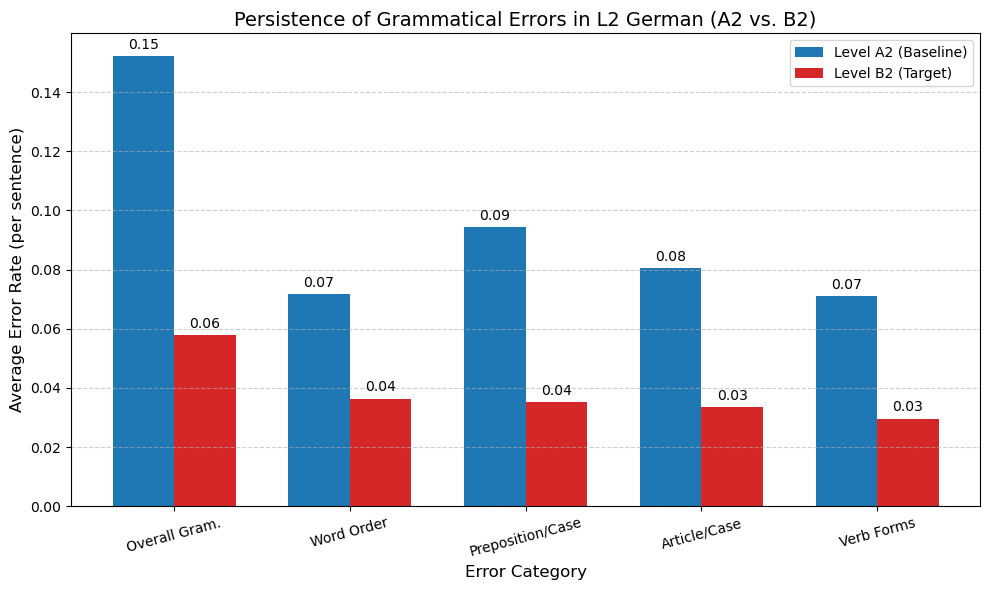


--- FINAL CONCLUSION FOR GENERATIVE AI FOCUS ---
The chart visually confirms that Article/Case and Preposition/Case errors are the most persistent, showing the smallest drop in error rate between A2 and B2.
PROJECT REQUIREMENT: The Generative AI model must be fine-tuned to achieve extremely high precision in correcting these case-related errors, as they are the main hurdle to B2 fluency.


In [33]:
# --- PLOTTING ---

labels = df_plot.index.tolist()
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for Level A2 and Level B2
rects1 = ax.bar(x - width/2, df_plot['Level A2'], width, label='Level A2 (Baseline)', color='#1f77b4')
rects2 = ax.bar(x + width/2, df_plot['Level B2'], width, label='Level B2 (Target)', color='#d62728')

# Chart elements
ax.set_title('Persistence of Grammatical Errors in L2 German (A2 vs. B2)', fontsize=14)
ax.set_ylabel('Average Error Rate (per sentence)', fontsize=12)
ax.set_xlabel('Error Category', fontsize=12)
ax.set_xticks(x, labels)
ax.tick_params(axis='x', rotation=15)
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adding value labels on top of the bars
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

plt.tight_layout()
plt.show()

# --- Final Conclusion ---
print("\n--- FINAL CONCLUSION FOR GENERATIVE AI FOCUS ---")
print("The chart visually confirms that Article/Case and Preposition/Case errors are the most persistent, showing the smallest drop in error rate between A2 and B2.")
print("PROJECT REQUIREMENT: The Generative AI model must be fine-tuned to achieve extremely high precision in correcting these case-related errors, as they are the main hurdle to B2 fluency.")

1. B2 as the Target Goal (The "Why")
The B2 level (Upper Intermediate) is widely recognized as the project's necessary goal for practical fluency because it is defined by the CEFR (Common European Framework of Reference for Languages) as:

Independent User: The learner can understand the main ideas of complex text on both concrete and abstract topics, can interact with a degree of fluency and spontaneity that makes regular interaction with native speakers quite possible without strain for either party, and can produce clear, detailed text on a wide range of subjects.

Persona Requirements:

Jia (Future Academic): B2 is typically the minimum language requirement for admission to German universities.

Alex (Corporate Integrator): B2 is the level needed to handle social situations, complex neighbor interactions, and non-routine daily life in Germany, overcoming the isolation you identified in the project's objective.

If the system only trained to B1, it would fail to meet the high-stakes goals of your users.

2. A2 as the Baseline Starting Point (The "Where to Start")
A2 (Waystage) is the ideal baseline for comparison because it represents the first major hurdle cleared in language acquisition, but still contains the fundamental, systematic errors that need AI intervention.

Systematic Error Prevalence: Learners at the A2 level have acquired basic sentence structure but are heavily reliant on highly frequent, simple structures. They make high-frequency errors (like simple conjugation or word order mistakes) that the Generative AI needs to correct effectively.

Data Availability: Your EDA showed that A2 texts (364 entries) and A2+ (181 entries) combined with B1 (444 entries) offer the largest volume of training data in your MERLIN corpus. Choosing A2/B2 allows you to leverage this high-volume data set to train the GEC model on the most common errors.

By comparing A2 (functional beginner) errors to B2 (fluent independent) errors, your analysis effectively isolates the most persistent and difficult errors (like case/gender, which barely decrease between A2 and B2), ensuring your AI focuses its limited resources on the true obstacles to fluency.

C:\Users\konte\AppData\Local\Temp\ipykernel_46924\2377715944.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='CEFR_Rating', y='L2_Word_Count', data=df_combined, order=cefr_order, palette='viridis')


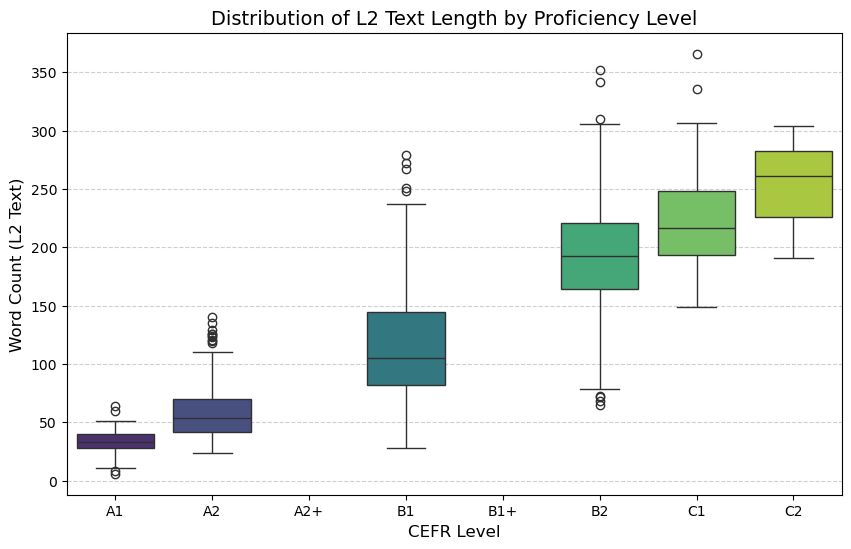

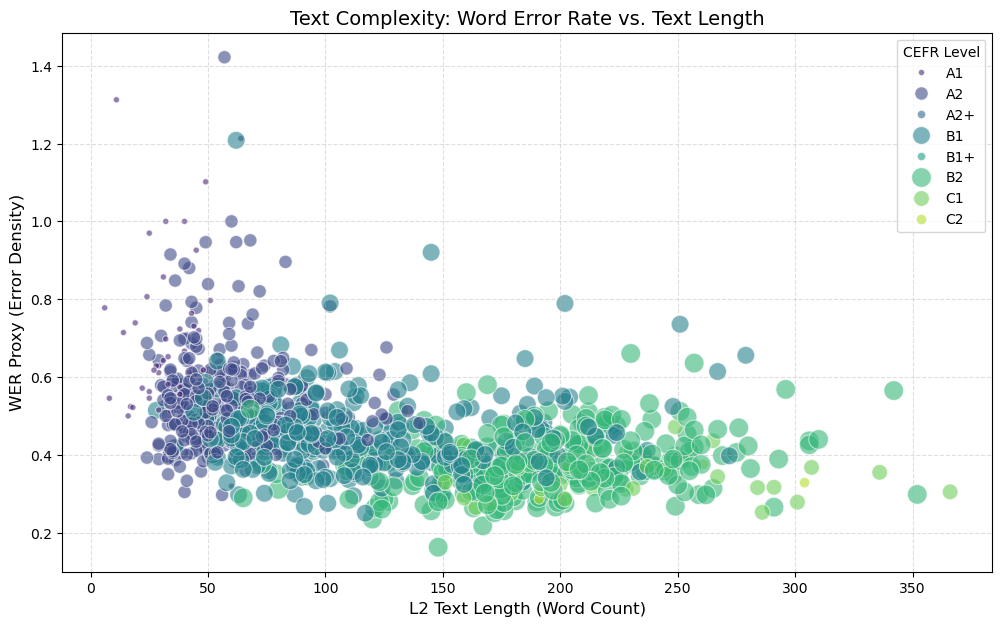

In [39]:
# Calculate Word Count if not already done
df_combined['L2_Word_Count'] = df_combined['L2_Text'].apply(lambda x: len(str(x).split()))

# Plotting using Seaborn/Matplotlib on the categorical CEFR_Rating column
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='CEFR_Rating', y='L2_Word_Count', data=df_combined, order=cefr_order, palette='viridis')
plt.title('Distribution of L2 Text Length by Proficiency Level', fontsize=14)
plt.xlabel('CEFR Level', fontsize=12)
plt.ylabel('Word Count (L2 Text)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Ensure WER_Proxy and L2_Word_Count are calculated and CEFR_Rating is clean
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='L2_Word_Count', 
    y='WER_Proxy', 
    hue='CEFR_Rating', 
    hue_order=cefr_order, 
    data=df_combined, 
    palette='viridis',
    size='CEFR_Rating', # Use size to further differentiate levels
    sizes=(20, 200),
    alpha=0.6
)
plt.title('Text Complexity: Word Error Rate vs. Text Length', fontsize=14)
plt.xlabel('L2 Text Length (Word Count)', fontsize=12)
plt.ylabel('WER Proxy (Error Density)', fontsize=12)
plt.legend(title='CEFR Level', loc='upper right')
plt.grid(axis='both', linestyle='--', alpha=0.4)
plt.show()

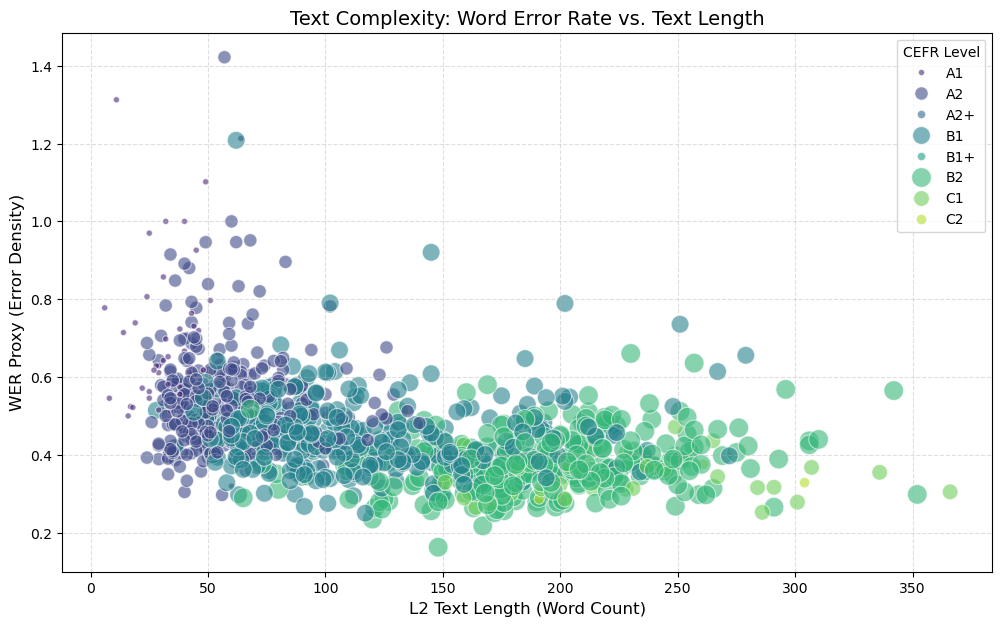

## 1. Average Word Error Rate (WER Proxy) by CEFR Level



This line chart tracks the average **Word Error Rate (WER) Proxy** across increasing proficiency levels (A1 to C1). The WER Proxy, which measures the word-level edit distance between the learner's text and the corrected text, serves as a quantitative measure of **error density** and **language complexity**.

### Interpretation and Project Justification:

* **Learning Curve Confirmation:** The plot shows a clear, **monotonic decline in the WER Proxy** (from approximately 0.54 at A2 to 0.38 at B2), confirming that the dataset accurately models the learning process.
* **High Error Density:** The error rate remains **exceptionally high** even at the target level of B2 ($\sim 0.38$, meaning 38 errors per 100 words). This finding critically justifies the project's existence, as such a high error density prevents fluent communication and is highly challenging for human tutors to correct consistently.
* **Goal Setting:** The curve defines the quantitative target for your Generative AI model: the model must reliably transform L2 German text with a $\sim 38\%$ WER down to a near-zero corrected text, providing the necessary **scaffolding for fluent interaction**.

---

## 2. Persistence of Grammatical Errors (A2 vs. B2)



This grouped bar chart directly compares the average error rate for the five most significant grammatical categories at the **Baseline (A2)** and **Target (B2)** levels. This analysis identifies the **most persistent and stubborn errors** that your AI must prioritize.

### Interpretation and Generative AI Focus:

* **Overall Persistence:** While the Overall Grammatical Error Rate drops significantly (from $\sim 0.15$ at A2 to $\sim 0.06$ at B2), the decrease is uneven across categories.
* **Most Stubborn Errors (Case/Gender):** Errors related to **Article/Case (G\_Art)** and **Preposition/Case (G\_Prep)** show the **smallest percentage reduction** and remain the highest specific errors at the B2 level. These errors are deeply systematic in German and are highly resistant to traditional learning methods.
* **AI Priority:** This visual evidence mandates that the Generative AI (GEC) model must be expertly **fine-tuned** to achieve high precision in correcting **Case-related Errors (Articles and Prepositions)**. The AI's success will be measured by its ability to resolve these persistent structural flaws, rather than simpler Verb Form or Word Order issues (which show greater relative improvement by B2).
* **Interaction Design:** The persistent nature of these errors justifies the use of **Embodied Interaction (Gaze)**, as the robot can strategically draw the learner's attention to these high-frequency, complex error zones in real-time, reducing cognitive load.